# Implementing Neural Network Training with Different Optimizers

### Objective:
The goal of this assignment is to implement a small neural network from scratch and train it using three different optimization algorithms: Stochastic Gradient Descent (SGD), SGD with Momentum, and SGD with AdaGrad. You will need to compare the performance of these optimizers.

## 1- Dataset

### Digits

This dataset, sourced from sklearn, consists of 1797 images, each sized 8x8 pixels. Every image, like the example shown below, depicts a handwritten digit. To utilize an 8x8 image, it must first be transformed into a feature vector of length 64.

The task with this dataset is to classify each digit, with a total of 10 classes.

The targets are one-hot encoded, i.e. each digit is transformed into a 10-dimensional vector with the element corresponding to the digit set to 1, and the other elements set to 0.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from typing import List, Tuple
from numpy.typing import NDArray
import numpy as np

digits = load_digits()
print("dataset's dimensions:", digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()


In [2]:
# this function loads train and test sets from digits dataset
def load_data() -> Tuple[NDArray, NDArray, NDArray, NDArray]:
    """ Loads the digits dataset and encodes it
    
    x is the data that will be passed to the model. Images are 8x8 transformed into 
    a 1 x 64 array in the training and test dataset
    y is the ground truth, it is a 1x10 array, where all the columns are 0 expect for the 
    ith column and is set to 1 => the digit is i (7th col = 1 => digit is 7) 
    
    :return: The training and test dataset
    """
    digits = load_digits()
    X = digits.data
    y = digits.target

    enc = OneHotEncoder()
    # encodes every element in y to into a 1x10 array as above
    # original value is like [1, 3, 8, 1 ...] so every element is transformed into its own 1x10 array
    y = enc.fit_transform(y.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test

## 2- Neural Network Architecture:
* Implement a simple feedforward neural network with one hidden layer.
* Use sigmoid activation for the hidden layer and softmax for the output layer.
* Feel free to add any necessary functions to the class below.
* See figure 2 in assignment pdf for a diagram

In [3]:
# Neural network forward and backward propagation
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """Initialize weights and biases
        
        :param input_size: size of input
        :param hidden_size: size of hidden layer
        :param output_size: size of output layer
        """
        # (64, 20)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        # (1, 20)
        self.b1 = np.zeros((1, hidden_size))
        # (20, 10)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        # (1, 10)
        self.b2 = np.zeros((1, output_size))
        
        # grads
        self.dW1 = np.zeros((input_size, hidden_size))
        self.db1 = np.zeros((1, hidden_size))
        self.dW2 = np.zeros((hidden_size, output_size))
        self.db2 = np.zeros((1, output_size))       
            
    def sigmoid(self, a: NDArray) -> NDArray:
        """
        Applies the sigmoid activation function on all elements of the input

        :param a: pre-activation values
        :return: post activation values
        """
        return 1 / (1 + np.exp(-a))

    def softmax(self, a: NDArray) -> NDArray:
        """
        Applies the softmax activation function on all elements of the input

        :param a: the pre-activation values
        :return: the post activation values
        """
        exp_a = np.exp(a)
        return exp_a / np.expand_dims(np.sum(exp_a, axis=-1), -1)

    def forward(self, X: NDArray) -> NDArray:
        """ Implement forward pass
        You should store the intermediate values as fields to be used by the backward pass
        The forward pass must work for all batch sizes

        X: the x values, batched along dimension zero
        return: z2
        """
        # X will have shape like (128, 64) where I the 128 is the batch size and 64 is the pixels of
        # the 8 x 8 image

        # calculate the a1 values. A1 shape (128, 20)
        self.a1 = np.matmul(X, self.W1) + self.b1
        
        # calculate the z1 values
        self.z1 = self.sigmoid(self.a1)

        # calculating the a2 values. A2 shape (128, 10)
        self.a2 = np.matmul(self.z1, self.W2) + self.b2

        # calculating the z2 (output) values
        self.z2 = self.softmax(self.a2)

        return self.z2

    def create_diag(self, diag_from: NDArray) -> NDArray:
        """Creates an array of 2d matrices (a 3d matrix) from a 2d matrix, where the rows of the 2d matrix becomes
        the diagonal values of each element in the array of 2d matrices.

        :param diag_from: the matrix to get a 3d diagonal from (2d). It is a (m x n) matrix
        :return: the 3rd matrix
        """
        # create n x n identity matrix
        temp = np.identity(np.shape(diag_from)[1])
        # add dim 0 => 1 x n x n
        temp = np.expand_dims(temp, axis=0)
        # repeat the 0th dim m times => m x n x n where the m diagonals is the identity
        temp = np.repeat(temp, np.shape(diag_from)[0], axis=0)
        # diag -> m x 1 x n
        diag_from = np.expand_dims(diag_from, axis=1)
        # make it m x n x n for matmul to be m x n x n
        diag_from = np.repeat(diag_from, np.shape(diag_from)[2], axis=1)
        return np.multiply(temp, diag_from) 

    def backward(self, X:NDArray, y:NDArray) -> None:
        """ Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        Use the intermediate values calculated from the forward pass, and store the gradients in fields
        The backward pass must also work for all batch sizes

        X: the x values, batched along dimension zero
        y: batched target values
        return: None
        """
        # calculating the gradients for the weights

        # output layer
        dE_dz2 = 2 * (self.z2 - y) / y.shape[0]
        dE_dz2 = np.expand_dims(dE_dz2, axis=1)  # 128, 1, 10
        # z2 is 128, 10
        # matmul of z2, z2 is 128, 128. we need 128,10,10
        # add a dim to z2 => (128, 10, 1) * (128, 1, 10) => (128, 10, 10)
        temp = np.matmul(np.expand_dims(self.z2, 2), -np.expand_dims(self.z2, 1))
        diag = self.create_diag(self.z2)  # diag is 128, 10, 10
        # the derivative of the softmax function batched
        dz2_da2 = temp + diag  # 128, 10, 10
        da2_dW2 = self.z1  # 128, 20
        dE_da2 = np.matmul(dE_dz2, dz2_da2)  # 128, 1, 10
        self.dW2 = np.matmul(np.expand_dims(da2_dW2, 2), dE_da2)  # 128, 20,10
        self.db2 = dE_da2  # 128, 1, 10

        # hidden layer
        # dE_dz1 is 128, 1, 10
        # W2 is 20, 10
        dE_dz1 = np.matmul(dE_da2, self.W2.T)  # 128, 1, 20

        # dz1_da1 = np.diag(self.z1 * (1 - self.z1)) # 128, 20, 20
        dz1_da1 = self.create_diag(self.z1 * (1 - self.z1))
        da1_dW1 = X  # 128, 64
        # dE_z1 is d2 * W2.T
        dE_da1 = np.matmul(dE_dz1, dz1_da1)  # 128, 1, 20
        self.dW1 = np.matmul(np.expand_dims(da1_dW1, 2), dE_da1)  # 128, 64, 20
        self.db1 = dE_da1

        # get rid of the batch size (128, n,m) -> (n, m)
        # self.dW2 = np.mean(self.dW2, axis=0)
        self.dW2 = np.sum(self.dW2, axis=0)
        self.db2 = np.sum(self.db2, axis=0)
        self.dW1 = np.sum(self.dW1, axis=0)
        self.db1 = np.sum(self.db1, axis=0)
        
    def get_params_and_grads(self) -> Tuple[List[NDArray], List[NDArray]]:
        """ Return parameters and corresponding gradients
        
        :return: parameters and corresponding gradients
        """
        params = [self.W1, self.b1, self.W2, self.b2]
        grads = [self.dW1, self.db1, self.dW2, self.db2]
        return params, grads


## 3- Helper Functions
Implement the following helper functions (the `plot_all_results` function is already implemented):

* `mean_squared_error(predictions, targets)`: This function receives the predicted values from the network and the target values, calculates the mean squared loss, and returns the loss value. For clarification, you should take the mean of the squared error over the samples in the batch, and *not* over the outputs of each sample

* `compute_accuracy(predictions, targets)`: This function receives the predicted values and the target values, and returns the accuracy of the predictions. The predicted value is the index with the highest network output (z2) value.

* Feel free to add any other necessary helper functions here.


In [4]:
def mean_squared_error(predictions: NDArray, targets: NDArray) -> float:
    """Returns MSE loss
    
    :param predictions: predicted values of the model
    :param targets: target values of the model (ground truth)
    :return: MSE loss
    """
    return np.mean((targets - predictions) ** 2)

def compute_accuracy(predictions: NDArray, targets: NDArray) -> float:
    """Returns the accuracy of the predicted labels (between 0 and 1)
    
    :param predictions: the predicted values of the model
    :param targets: the target values of the model (ground truth)
    :return: the accuracy of the predicted labels 
    """
    num_correct = 0
    for i in range(len(targets)):
        if np.argmax(targets[i]) == np.argmax(predictions[i]):
            num_correct += 1
    
    return num_correct / len(targets)

def plot_all_results(all_losses: NDArray, all_accuracies: NDArray, all_labels: List[str]) -> None:
    """ Plots and displays the losses and accuracies of different optimizers against each other
    
    :param all_losses: Losses of different optimizers
    :param all_accuracies: Accuracies of different optimizers
    :param all_labels: Names of different optimizers with their learning rate
    """
    if len(all_losses) != len(all_accuracies):
      raise ValueError("all_losses length must be equal to all_accuracies length")

    if len(all_losses) != len(all_labels):
      raise ValueError("all_labels length must be equal to all_losses length")

    epochs = len(all_losses[0])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_losses[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(f'Training loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_accuracies[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title(f'Training accuracy')

    plt.legend()
    plt.show()

# You may add helper functions here

## 4- Optimizer Implementations:
Implement the following optimization algorithms:

 * Stochastic Gradient Descent with minibatches (SGD)
 * SGD with Momentum
 * SGD with AdaGrad

Note that you must update each param in-place using `+=` or `-=` so that the weights of the network are updated.

In [5]:
# Optimizer implementations (SGD, SGD with Momentum, AdaGrad)
class SGD():
    """Performs a step in gradient descent using SGD"""
    def __init__(self, params: NDArray, learning_rate: float) -> None:
        self.params = params
        self.lr = learning_rate

    def step(self, grads: List['np.ndarray']) -> None:
        # Perform one step of SGD
        for i in range(len(grads)):
            self.params[i] -= self.lr * grads[i] 
        
        
class SGD_Momentum():
    """Performs a step in gradient descent using SGD with momentum"""
    def __init__(self, params: NDArray, learning_rate: float, alpha: float) -> None:
        self.params = params
        self.lr = learning_rate
        # momentum param
        self.alpha = alpha       
        if len(params) == 4:
            # NN only has 2 layers:
            self.velocity = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
        else:
            # NN has 3 layers
            self.velocity = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]

    def step(self, grads: NDArray) -> None:
        # grads = [self.dW1, self.db1, self.dW2, self.db2]
        for i in range(len(grads)):
            self.velocity[i] = (self.alpha * self.velocity[i]) - (self.lr * grads[i])
            self.params[i] += self.velocity[i]


class SGD_AdaGrad():
    """Performs a step in gradient descent using SGD with Adaptive Gradients"""
    def __init__(self, params: NDArray, learning_rate: float, delta: float) -> None:
        self.params = params
        self.lr = learning_rate
        self.delta = delta
        if len(params) == 4:
            # NN only has 2 layers:
            self.r = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
        else:
            # NN has 3 layers
            self.r = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]

    def step(self, grads: NDArray) -> None:
        # Perform one step of SGD with adagrad
        for i in range(len(grads)):
            self.r[i] += np.multiply(grads[i], grads[i])
            delta_theta = np.multiply(-self.lr / (self.delta + np.sqrt(self.r[i])), grads[i])
            self.params[i] += delta_theta
            

class SGD_Adam():
    """Performs a step in gradient descent using SGD with Adaptive Moments"""
    def __init__(self, params: NDArray, learning_rate: float, p1: float, p2: float, delta: float) -> None:
        self.params = params
        self.lr = learning_rate
        self.delta = delta
        self.p1 = p1
        self.p2 = p2
        self.t = 0
        if len(params) == 4:
            # NN only has 2 layers:
            self.r = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
            self.s = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
        else:
            # NN has 3 layers
            self.r = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
            self.s = [np.zeros((64, 20)), np.zeros((1, 20)), np.zeros((20, 20)), np.zeros((1, 20)), np.zeros((20, 10)), np.zeros((1, 10))]
        
    def step(self, grads: NDArray) -> None:
        # Perform one step of SGD with adagrad
        for i in range(len(grads)):
            self.t += 1
            self.s[i] = (p1 * s[i]) + (1 - p1) * grads[i]
            self.r[i] = (p2 * r[i]) + (1 - p2) * np.multiply(grads[i], grads[i])
            # correcting biases 
            s_hat = s / (1 - p1 ** t)
            r_hat = r / (1 - p2 ** t)
            
            delta_theta = -self.lr * s_hat / (sqrt(r_hat) + delta) 
            self.params[i] += delta_theta


## 5- Training Loop:

The `train` function is used to train your neural network. It returns the training loss and accuracy after each epoch.


In [6]:
#batch generator
def gen_batches(data, labels, batch_size):
    """Batches the data set
    
    :return: training data and labels
    """
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size], labels[i:i+batch_size]

# Training loop
def train(network, data, optimizer, epochs, batch_size):
    X_train, y_train, X_test, y_test = data
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        random_indices = np.random.permutation(list(range(X_train.shape[0])))
        X_train = X_train[random_indices]
        y_train = y_train[random_indices]
        for x, y in gen_batches(X_train, y_train, batch_size):
            # Forward pass
            output = network.forward(x)
        
            # Backward pass
            network.backward(x, y)
        
            # Get parameters and gradients
            params, grads = network.get_params_and_grads()
        
            # Update parameters using the chosen optimizer
            optimizer.step(grads)
        
        # Compute loss and accuracy
        X_test = X_train
        y_test = y_train
        output = network.forward(X_test)
        train_loss = mean_squared_error(output, y_test)
        train_accuracy = compute_accuracy(output, y_test)
    
        test_losses.append(train_loss)
        test_accuracies.append(train_accuracy)
    
        if epoch % 20 == 19:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    return test_losses, test_accuracies

## 6- Main function
Use the following main function to train your neural network based on sgd, sgd-momentum, and AdaGrad. The following hyperparameters are used in training:

* batch_size = 128
* input_size = 64
* hidden_size = 20
* output_size = 10
* learning_rate = see LR on graph legend
* For SGD with momentum, alpha = 0.9
* For SGD with AdaGrad, delta = 10^-8
* For SGD with Adam, delta = 10^-8, p1 = 0.9, p2 = 0.999
* epochs = 200

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.0128, Accuracy: 0.9422
Epoch 40/200, Loss: 0.0045, Accuracy: 0.9791
Epoch 60/200, Loss: 0.0032, Accuracy: 0.9854
Epoch 80/200, Loss: 0.0012, Accuracy: 0.9986
Epoch 100/200, Loss: 0.0009, Accuracy: 0.9986
Epoch 120/200, Loss: 0.0007, Accuracy: 0.9986
Epoch 140/200, Loss: 0.0006, Accuracy: 0.9986
Epoch 160/200, Loss: 0.0005, Accuracy: 0.9986
Epoch 180/200, Loss: 0.0005, Accuracy: 0.9993
Epoch 200/200, Loss: 0.0004, Accuracy: 0.9993
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.0418, Accuracy: 0.7418
Epoch 40/200, Loss: 0.0126, Accuracy: 0.9673
Epoch 60/200, Loss: 0.0069, Accuracy: 0.9736
Epoch 80/200, Loss: 0.0035, Accuracy: 0.9923
Epoch 100/200, Loss: 0.0026, Accuracy: 0.9937
Epoch 120/200, Loss: 0.0021, Accuracy: 0.9958
Epoch 140/200, Loss: 0.0016, Accuracy: 0.9965
Epoch 160/200, Loss: 0.0014, Accuracy: 0.9972
Epoch 180/200, Loss: 0.0013, Accuracy: 0.9972
Epoch 200/200, Loss: 0.0011, Accuracy: 0.9972
Training with SGD with Momentum LR 0.0

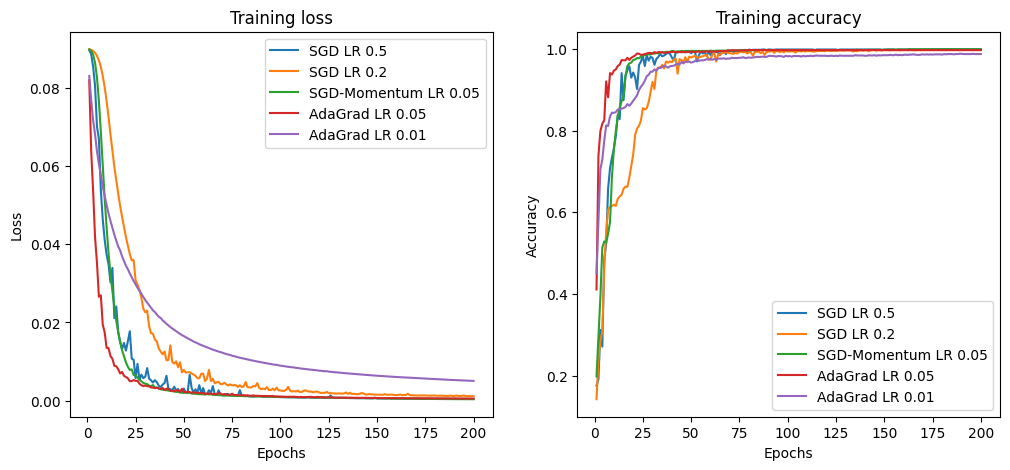

In [7]:
# Main function to run the experiments
def main():
    data = load_data()
    batch_size = 128
    input_size = 64  # For the digits dataset (8x8 images flattened)
    hidden_size = 20
    output_size = 10
    epochs = 200

    # print("Training with SGD LR 0.5")
    # network = NeuralNetwork(input_size, hidden_size, output_size)
    # test_losses_sgd, test_accuracies_sgd = train(network, data, SGD(network.get_params_and_grads()[0], 0.5), epochs, batch_size)
    # 
    # print("Training with SGD LR 0.2")
    # network = NeuralNetwork(input_size, hidden_size, output_size)
    # test_losses_sgd_b, test_accuracies_sgd_b = train(network, data, SGD(network.get_params_and_grads()[0], 0.2), epochs, batch_size)
    # 
    # print("Training with SGD with Momentum LR 0.05")
    # network = NeuralNetwork(input_size, hidden_size, output_size)
    # test_losses_momentum, test_accuracies_momentum = train(network, data, SGD_Momentum(network.get_params_and_grads()[0], 0.05, 0.9), epochs, batch_size)
    # 
    # print("Training with AdaGrad LR 0.05")
    # network = NeuralNetwork(input_size, hidden_size, output_size)
    # test_losses_adagrad, test_accuracies_adagrad = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.05, 1e-8), epochs, batch_size)
    # 
    # print("Training with AdaGrad LR 0.01")
    # network = NeuralNetwork(input_size, hidden_size, output_size)
    # test_losses_adagrad_b, test_accuracies_adagrad_b = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.01, 1e-8), epochs, batch_size)
    
    print("Training with Adam LR 0.001")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_adam, test_accuracies_adam = train(network, data, SGD_Adam(network.get_params_and_grads()[0], 0.001, 0.9, 0.999, 1e-8), epochs, batch_size)

    # # Compare train losses and train accuracies
    # all_losses = [test_losses_sgd, test_losses_sgd_b, test_losses_momentum, test_losses_adagrad, test_losses_adagrad_b]
    # all_accuracies = [test_accuracies_sgd, test_accuracies_sgd_b, test_accuracies_momentum, test_accuracies_adagrad, test_accuracies_adagrad_b]
    # all_labels = ["SGD LR 0.5", "SGD LR 0.2", "SGD-Momentum LR 0.05", "AdaGrad LR 0.05", "AdaGrad LR 0.01", "Adam LR 0,001"]
    # plot_all_results(all_losses, all_accuracies, all_labels)

if __name__ == "__main__":
    main()

## 7. Increasing Layers

Instead of using 2-layer neural networks. We can increase number of layers to three and observe the loss again based on sgd. The newly added layer should adopt the same hidden size.

We are sticking to the same hyper-parameters as before.

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.0900, Accuracy: 0.1009
Epoch 40/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 60/200, Loss: 0.0900, Accuracy: 0.1016
Epoch 80/200, Loss: 0.0896, Accuracy: 0.2039
Epoch 100/200, Loss: 0.0816, Accuracy: 0.2150
Epoch 120/200, Loss: 0.0747, Accuracy: 0.3034
Epoch 140/200, Loss: 0.0704, Accuracy: 0.4551
Epoch 160/200, Loss: 0.0586, Accuracy: 0.4732
Epoch 180/200, Loss: 0.0472, Accuracy: 0.7230
Epoch 200/200, Loss: 0.0241, Accuracy: 0.9088
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 40/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 60/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 80/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 100/200, Loss: 0.0900, Accuracy: 0.1009
Epoch 120/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 140/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 160/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 180/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 200/200, Loss: 0.0900, Accuracy: 0.1072
Training with SGD with Momentum LR 0.0

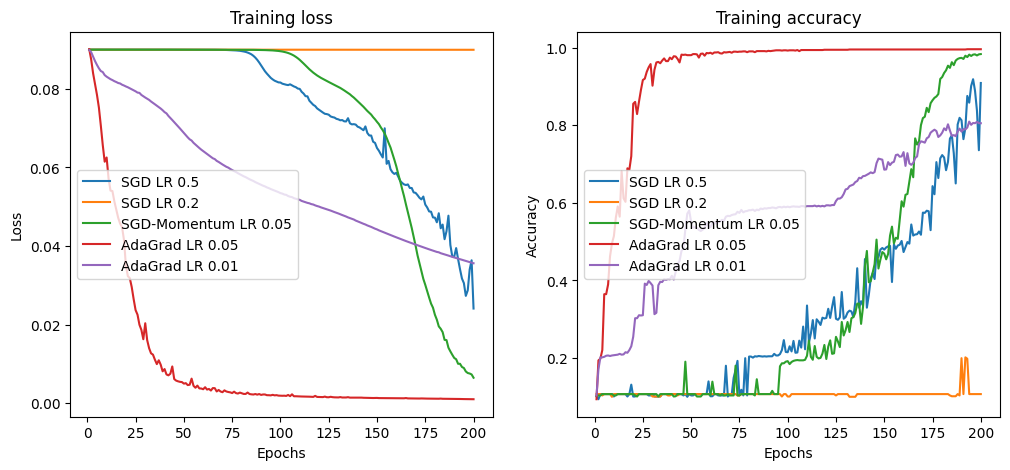

In [9]:
class NeuralNetwork:
    """Same NN but with an additional layer"""
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        # (64, 20)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        # (1, 20)
        self.b1 = np.zeros((1, hidden_size))
        # (20, 20)
        self.W2 = np.random.randn(hidden_size, hidden_size) * 0.01
        # (1, 20)
        self.b2 = np.zeros((1, hidden_size))
        # (20, 10)
        self.W3 = np.random.randn(hidden_size, output_size) * 0.01
        # (1, 10)
        self.b3 = np.zeros((1, output_size))

        self.dW1 = np.zeros((input_size, hidden_size))
        self.db1 = np.zeros((1, hidden_size))
        self.dW2 = np.zeros((hidden_size, hidden_size))
        self.db2 = np.zeros((1, output_size))  
        self.dW3 = np.zeros((hidden_size, output_size))
        self.db3 = np.zeros((1, output_size))       
            
    def sigmoid(self, a):
        """
        Sigmoid activation function

        :param a: pre-activation values
        :return: post activation values
        """
        return 1 / (1 + np.exp(-a))

    def softmax(self, a):
        """
        Softmax activation function

        :param a: the pre-activation values
        :return: the post activation values
        """
        exp_a = np.exp(a)
        return exp_a / np.expand_dims(np.sum(exp_a, axis=-1), -1)

    def forward(self, X):
        """
        # Implement forward pass
        # You should store the intermediate values as fields to be used by the backward pass
        # The forward pass must work for all batch sizes

        # X: the x values, batched along dimension zero
        # return: z2
        """
        # X will have shape like (128, 64) where I think the 128 is the batch size and 64 is the pixels of
        # the 8 x 8 image

        # calculate the a1 values. A1 shape (128, 20)
        self.a1 = np.matmul(X, self.W1) + self.b1
        # print(f"pre sigmoid shape: {self.a1.shape}, pre sigmoid values:\n{self.a1}")
        
        # calculate the z1 values
        self.z1 = self.sigmoid(self.a1)
        # print(f"post sigmoid shape: {self.z1.shape}, post sigmoid values:\n{self.z1}")

        # calculating the a2 values. A2 shape (20, 20)
        self.a2 = np.matmul(self.z1, self.W2) + self.b2

        # calculating the z2 (output) values
        self.z2 = self.sigmoid(self.a2)
        
        # calculating the a3 values (20, 10)
        self.a3 = np.matmul(self.z2, self.W3) + self.b3
        
        # calculating the output z3
        self.z3 = self.softmax(self.a3)

        return self.z3

    def create_diag(self, diag_from):
        """Creates a 3d diagonal matrix from a 2d one, where the rows of the 2d matrix becomes
        the diagonal values of the 3d matrix

        :param diag_from: the matrix to get a 3d diagonal from (2d). It is a (m x n) matrix
        """
        # create n x n identity matrix
        temp = np.identity(np.shape(diag_from)[1])
        # add dim 0 => 1 x n x n
        temp = np.expand_dims(temp, axis=0)
        # repeat the 0th dim m times => m x n x n where the m diagonals is the identity
        temp = np.repeat(temp, np.shape(diag_from)[0], axis=0)
        # diag -> m x 1 x n
        diag_from = np.expand_dims(diag_from, axis=1)
        # make it m x n x n for matmul to be m x n x n
        diag_from = np.repeat(diag_from, np.shape(diag_from)[2], axis=1)
        out = np.multiply(temp, diag_from)
        return out

    def backward(self, X, y):
        """
        Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        Use the intermediate values calculated from the forward pass,
        and store the gradients in fields
        The backward pass must also work for all batch sizes

        X: the x values, batched along dimension zero
        y: batched target values
        return: None
        """
        # Attempt at batched backwards pass
        # calculating the gradients for the weights

        # output layer
        dE_dz3 = 2 * (self.z3 - y) / y.shape[0]
        dE_dz3 = np.expand_dims(dE_dz3, axis=1)  # 128, 1, 10
        # z2 is 128, 10
        # add a dim to z3 => (128, 10, 1) * (128, 1, 10) => (128, 10, 10)
        temp = np.matmul(np.expand_dims(self.z3, 2), -np.expand_dims(self.z3, 1))
        diag = self.create_diag(self.z3)  # diag is 128, 10, 10
        # the derivative of the softmax function batched
        dz3_da3 = temp + diag  # 128, 10, 10
        da3_dW3 = self.z2  # 128, 20
        dE_da3 = np.matmul(dE_dz3, dz3_da3)  # 128, 1, 10
        self.dW3 = np.matmul(np.expand_dims(da3_dW3, 2), dE_da3)  # 128, 20,10
        self.db3 = dE_da3  # 128, 1, 10

        # hidden layer #1
        # W3 is 20, 10 -> W3.T is 10, 20
        dE_dz2 = np.matmul(dE_da3, self.W3.T)  # 128, 1, 20, this is the current delta 
        # diagonal jacobian matrix
        dz2_da2 = self.create_diag(self.z2 * (1 - self.z2)) # 128, 20, 20
        da2_dW2 = self.z1  # 128, 20
        dE_da2 = np.matmul(dE_dz2, dz2_da2)  # 128, 1, 20
        self.dW2 = np.matmul(np.expand_dims(da2_dW2, 2), dE_da2)  # 128, 20, 20
        self.db2 = dE_da2
        
        # hidden layer #2
        dE_dz1 = np.matmul(dE_da2, self.W2.T)  # 128, 1, 20, cur delta
        dz1_da1 = self.create_diag(self.z1 * (1 - self.z1))  # 128, 20, 20
        da1_dW1 = X  # 128, 64
        dE_da1 = np.matmul(dE_dz1, dz1_da1)  # 128, 1, 20
        self.dW1 = np.matmul(np.expand_dims(da1_dW1, 2), dE_da1)  # 128, 64, 20
        self.db1 = dE_da1
        

        # get rid of the batch size (128, n,m) -> (n, m)
        # self.dW2 = np.mean(self.dW2, axis=0)
        self.dW3 = np.sum(self.dW3, axis=0)
        self.db3 = np.sum(self.db3, axis=0)
        self.dW2 = np.sum(self.dW2, axis=0)
        self.db2 = np.sum(self.db2, axis=0)
        self.dW1 = np.sum(self.dW1, axis=0)
        self.db1 = np.sum(self.db1, axis=0)
        
    def get_params_and_grads(self):
        # Return parameters and corresponding gradients
        params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        grads = [self.dW1, self.db1, self.dW2, self.db2, self.dW3, self.db3]
        return params, grads


main()